In [6]:
import json
import pickle
from itertools import combinations
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.callback import Callback
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
import multiprocessing
from pymoo.core.problem import StarmapParallelization
from pymoo.visualization.scatter import Scatter
import logging
import sys
from pymoo.core.repair import Repair
from pymoo.termination import get_termination
import json
import pickle
from itertools import combinations
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.repair import Repair
from multiprocessing import Pool
import logging
import sys
from pymoo.core.problem import Problem
from pymoo.termination import get_termination

In [7]:
repair_mode = True

In [4]:
class WindEnergySiteSelectionProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        # super().__init__(n_var=gdf_optimization.shape[0], n_obj=2, n_ieq_constr=0, xl=0.0, xu=1.0)
        if repair_mode:
            super().__init__(n_var=points.shape[0], n_obj=2, n_ieq_constr=0, xl=0.0,
                             xu=1.0, **kwargs)  # Bearbeitet weil v_var nicht mehr gepasst hat
        else:
            super().__init__(n_var=points.shape[0], n_obj=2, n_ieq_constr=1, xl=0.0,
                             xu=1.0, **kwargs)  # Bearbeitet weil v_var nicht mehr gepasst hat

    def _evaluate(self, x, out, *args, **kwargs):
        indices = np.where(x)[0]
        combs = combinations(indices, 2)
        constraints_np = -1

        def repair(x1, x2):
            x[x1] = False

        for combination in combs:
            if combination[0] and combination[1]:
                WKA1 = points[combination[0]]
                WKA2 = points[combination[1]]
                WKA1_type = WKAs[WKA1[0]]
                WKA2_type = WKAs[WKA2[0]]
                d = WKA1[1].distance(WKA2[1])
                if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
                    if repair_mode:
                        repair(combination[0], combination[1])
                    else:
                        constraints_np = 1
                        break

        vals = np.where(x, points[:, 0], "")

        uniques, count = np.unique(vals, return_counts=True)

        type_prices = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            building_price = WKAs[item]["price"]["price_building"]
            price_per_year = WKAs[item]["price"]["price_per_year"]
            sum_price_one = building_price + (price_per_year * WKAs[item]["life_expectancy_in_years"])
            type_prices[item] = sum_price_one

        for key, value in type_prices.items():
            vals[vals == key] = value
        vals[vals == ""] = 0
        vals_sum = np.sum(vals)

        # Grundlage für Energieberechnung https://www.energie-lexikon.info/megawattstunde.html
        vals_ = np.where(x, points[:, 0], "")
        uniques, count = np.unique(vals_, return_counts=True)

        type_energy = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            nominal_power = WKAs[item]["nominal_power_in_kW"]
            lifetime_hours = WKAs[item][
                                 "life_expectancy_in_years"] * 8760  # Laut google ist 1 Jahr 8760 stunden # trifft nicht auf schaltjahre zu. Dort sind es 8784
            kwh = nominal_power * lifetime_hours
            type_energy[item] = kwh

        for key, value in type_energy.items():
            vals_[vals_ == key] = value
        vals_[vals_ == ""] = 0
        vals__sum = np.sum(vals_)

        out["F"] = np.column_stack([vals_sum, vals__sum])
        if not repair_mode:
            out["G"] = np.asarray([constraints_np])


class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.off = {}

    def notify(self, algorithm):
        logging.info("Callbackk Call")
        self.off[algorithm.n_gen] = algorithm



In [8]:
class CustomRepair(Repair):

    def repair_mp(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        for combination in combs:
            if combination[0] and combination[1]:
                WKA1 = points[combination[0]]
                WKA2 = points[combination[1]]
                WKA1_type = WKAs[WKA1[0]]
                WKA2_type = WKAs[WKA2[0]]
                d = WKA1[1].distance(WKA2[1])
                if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
                    row[combination[0]] = False
        return (idx, row)

    def _do(self, problem, X, **kwargs):
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        res = pool.map(self.repair_mp, zip(row_gen, indices))
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            X[idx, :] = item
        return X



class WindEnergySiteSelectionProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=points.shape[0], n_obj=2, n_ieq_constr=1, xl=0.0,
                         xu=1.0, **kwargs)  # Bearbeitet weil v_var nicht mehr gepasst hat


    def const_check(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        constraints_np = -1
        for combination in combs:
            if combination[0] and combination[1]:
                WKA1 = points[combination[0]]
                WKA2 = points[combination[1]]
                WKA1_type = WKAs[WKA1[0]]
                WKA2_type = WKAs[WKA2[0]]
                d = WKA1[1].distance(WKA2[1])
                if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
                    constraints_np = 1
                    break
        return (idx, constraints_np)

    def _evaluate(self, X, out, *args, **kwargs):

        constraints_np = np.zeros((X.shape[0]))
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        res = pool.map(self.const_check, zip(row_gen, indices))
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            constraints_np[idx] = item




        vals = np.where(X, points[:, 0], "")

        uniques, count = np.unique(vals, return_counts=True)

        type_prices = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            building_price = WKAs[item]["price"]["price_building"]
            price_per_year = WKAs[item]["price"]["price_per_year"]
            sum_price_one = building_price + (price_per_year * WKAs[item]["life_expectancy_in_years"])
            type_prices[item] = sum_price_one

        for key, value in type_prices.items():
            vals[vals == key] = value
        vals[vals == ""] = 0
        vals_sum = np.sum(vals, axis=1)


        # Grundlage für Energieberechnung https://www.energie-lexikon.info/megawattstunde.html
        vals_ = np.where(X, points[:, 0], "")
        uniques, count = np.unique(vals_, return_counts=True)

        type_energy = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            nominal_power = WKAs[item]["nominal_power_in_kW"]
            lifetime_hours = WKAs[item][
                                 "life_expectancy_in_years"] * 8760  # Laut google ist 1 Jahr 8760 stunden # trifft nicht auf schaltjahre zu. Dort sind es 8784
            kwh = nominal_power * lifetime_hours
            type_energy[item] = kwh

        for key, value in type_energy.items():
            vals_[vals_ == key] = value
        vals_[vals_ == ""] = 0
        vals__sum = np.sum(vals_, axis=1)
        vals__sum = -vals__sum

        out["F"] = np.column_stack([vals_sum, vals__sum])
        out["G"] = np.asarray([constraints_np])


In [14]:
class CustomRepair(Repair):

    def repair_mp(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        for combination in combs:
            if combination[0] and combination[1]:
                WKA1 = points[combination[0]]
                WKA2 = points[combination[1]]
                WKA1_type = WKAs[WKA1[0]]
                WKA2_type = WKAs[WKA2[0]]
                d = WKA1[1].distance(WKA2[1])
                if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
                    r_choice_list = [combination[0], combination[1]]
                    row[random.choice(r_choice_list)] = False
        return (idx, row)

    def _do(self, problem, X, **kwargs):
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        res = pool.map(self.repair_mp, zip(row_gen, indices))
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            X[idx, :] = item
        return X



class WindEnergySiteSelectionProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=points.shape[0], n_obj=2, n_ieq_constr=1, xl=0.0,
                         xu=1.0, **kwargs)  # Bearbeitet weil v_var nicht mehr gepasst hat


    def const_check(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        constraints_np = -1
        for combination in combs:
            if combination[0] and combination[1]:
                WKA1 = points[combination[0]]
                WKA2 = points[combination[1]]
                WKA1_type = WKAs[WKA1[0]]
                WKA2_type = WKAs[WKA2[0]]
                d = WKA1[1].distance(WKA2[1])
                if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
                    constraints_np = 1
                    break
        return (idx, constraints_np)

    def _evaluate(self, X, out, *args, **kwargs):

        constraints_np = np.zeros((X.shape[0]))
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        res = pool.map(self.const_check, zip(row_gen, indices))
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            constraints_np[idx] = item




        vals = np.where(X, points[:, 0], "")

        uniques, count = np.unique(vals, return_counts=True)

        type_prices = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            building_price = WKAs[item]["price"]["price_building"]
            price_per_year = WKAs[item]["price"]["price_per_year"]
            sum_price_one = building_price + (price_per_year * WKAs[item]["life_expectancy_in_years"])
            type_prices[item] = sum_price_one

        for key, value in type_prices.items():
            vals[vals == key] = value
        vals[vals == ""] = 0
        vals_sum = np.sum(vals, axis=1)


        # Grundlage für Energieberechnung https://www.energie-lexikon.info/megawattstunde.html
        vals_ = np.where(X, points[:, 0], "")
        uniques, count = np.unique(vals_, return_counts=True)

        type_energy = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            nominal_power = WKAs[item]["nominal_power_in_kW"]
            lifetime_hours = WKAs[item][
                                 "life_expectancy_in_years"] * 8760  # Laut google ist 1 Jahr 8760 stunden # trifft nicht auf schaltjahre zu. Dort sind es 8784
            kwh = nominal_power * lifetime_hours
            type_energy[item] = kwh

        for key, value in type_energy.items():
            vals_[vals_ == key] = value
        vals_[vals_ == ""] = 0
        vals__sum = np.sum(vals_, axis=1)
        vals__sum = -vals__sum

        out["F"] = np.column_stack([vals_sum, vals__sum])
        out["G"] = np.asarray([constraints_np])



In [9]:
with open(r"C:\workspace\Study_Project_Wind_Energy\Results\Reduced Area Repair Excluded\result.pkl", "rb") as file:
    res = pickle.load(file)

In [10]:
res

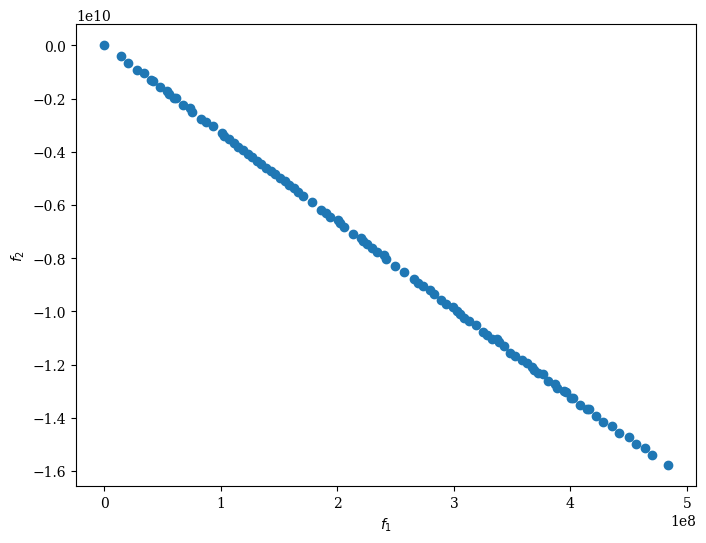

In [11]:
Scatter().add(res.F).show()

In [12]:
with open(r"C:\workspace\Study_Project_Wind_Energy\Results\Reduced Area Repair Included\result.pkl", "rb") as file:
    res2 = pickle.load(file)

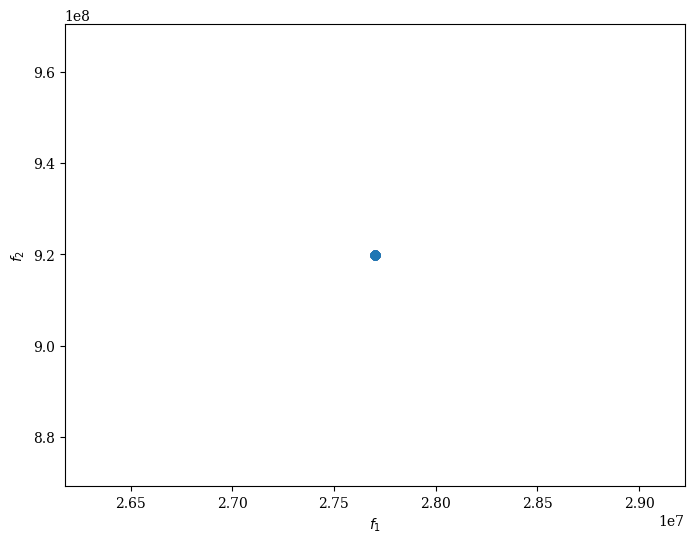

In [13]:
Scatter().add(res2.F).show()

In [15]:
with open(r"C:\workspace\Study_Project_Wind_Energy\Results\Reduced Area Repair Excluded Randomized\result.pkl", "rb") as file:
    res3 = pickle.load(file)

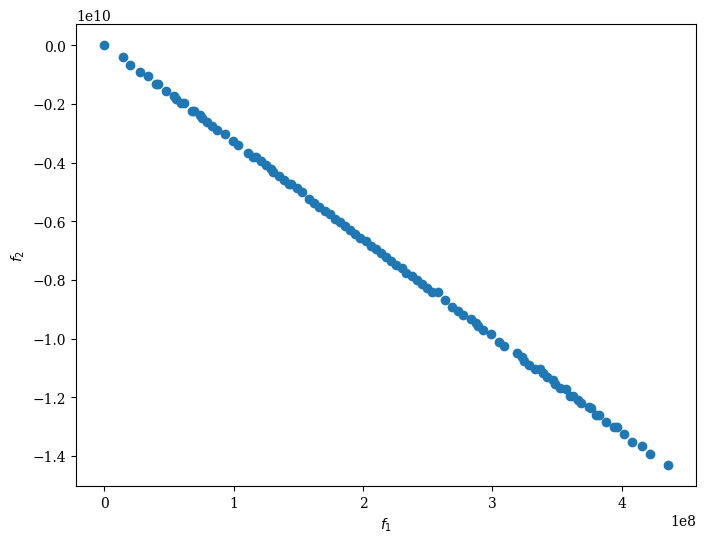

In [16]:
Scatter().add(res3.F).show()